# What this script does ?

This notebook is used to calculate representative days used in the EPM model. The script is divided into 4 parts:
1. Extract renewables generation data from Ninja API.
2. Calculate representative year among historical data.
3. Calculate special and representatative days within this year.
4. Export pHours, pVREgen in EPM format.

It is based on previously developed GAMS code for the Poncelet algorithm. The objective has been to automate the process and make it more user-friendly.
The code will automatically get the min production for PV, the min production for Wind, and the max load days for each season, called the special days.
It will automatically removes the special days from the input file for the Poncelet algorithm and then runs the Poncelet algorithm to generate the representative days.

## Installation
It's recommended to install a conda environment based on the `requirements.txt` file to run this script.
In order to do so, you can run the following command in your terminal: 
```bash
conda create --name myenv --file requirements.txt
```
If there are some dependencies issues because some package are not included (project is still under construction) in the `requirements.txt` file, install them manually. 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from utils import get_years_renewables, find_special_days, format_optim_repr_days, launch_optim_repr_days, parse_repr_days, format_epm_phours, format_epm_pvreprofile, format_data_energy, removed_special_days, format_epm_demandprofile, plot_dispatch 

### User input parameters (to manually change)

User needs to change the following parameters in the following cell:
1. `name_data` : Name of the data file to be saved.
2. `extract_renewables` : Whether to extract renewables data from Ninja API or not. If False, the script will use the data file provided by the user. Please note that dowloading data from Ninja API is time consuming, so do it only once. Also, there are API limits, so it is better to download the data once and use it multiple times.
3. `locations` : Coordinates of the location for which the data is to be extracted. The format is (latitude, longitude).
4. `power_types` : Types of power for which the data is to be extracted. The format is ['solar', 'wind'].
5. `start_year` : Start year of the historical data.
6. `end_year` : End year of the historical data.

In [2]:
name_data = 'guinea' # Name of the zone, used to name the folder where the data is stored
main_folder = os.path.join('data', name_data)
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

extract_renewables = {'solar': False, 'wind': False} # Set to True to extract data from Renewables Ninja

# If extract_renewables is True, fill the following variables
locations = [(10.1154, -13.1917)] # List of (latitude, longitude) tuples
power_types = ['solar', 'wind'] # 'wind' or 'solar'
start_year = 1980 # earliest year is 1980
end_year = 2024


### Create the folder structure

The following cell creates the folder structure required for the script to run.
1. The `main_folder` is `data/name_data/`.
2. In `data/name_data/raw_data/`, the raw data is stored, including the data from Ninja API.
3. In `data/name_data/repr_days/`, the representative days are stored, as well as some auxiliary files.

In [3]:
folder_raw_data = os.path.join(main_folder, 'raw_data')
# Make folder
if not os.path.exists(folder_raw_data):
    os.makedirs(folder_raw_data)
    
main_folder = os.path.join(main_folder, 'repr_days')
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

### 1. Extract data from Renewables Ninja

Depends on the `extract_renewables` parameter, the script will extract the data from the Ninja API or use the data file provided by the user.

In [4]:
for power_type in power_types:
    if extract_renewables[power_type]:
        get_years_renewables(locations=locations, power_type=power_type, start_year=start_year, 
                            end_year=end_year, name_data=name_data, output=folder_raw_data)

### 2. Process data

Here, you need to specifiy the location of the data file. The script will process the data and calculate the representative year.
For `Load` data that is typically not available in the Ninja API, user need to provide a `.csv` file with columns `season`, `day`, `hour`.
The data should have a header with the columns names as well as 8760 rows for each hour of the year. 

The script can handle multiple columns that are considered different load years, and will calculate the representative year to start the algorithm.

In [5]:
# If extract_renewables is False, fill the following variables
filenames = {'PV': [os.path.join(folder_raw_data, 'data_{}_solar.csv'.format(name_data)), 'renewable_ninja'],
             #'Wind': [os.path.join(folder_raw_data, 'data_{}_wind.csv'.format(name_data)), 'renewable_ninja'],
             #'Load': [os.path.join(folder_raw_data, 'data_guinea_load.csv'), 'standard']
             'Load': [os.path.join(folder_raw_data, 'load_data_synthetic_flat.csv'), 'standard']
             }
            

Here, all the data is processed and the representative year is calculated in one cell !

In [6]:
# Read, select representative year and format the data from .csv files
df_energy = format_data_energy(filenames)
# Find special days and remove them
special_days = find_special_days(df_energy, columns=[i for i in df_energy.columns if i not in ['season', 'day', 'hour', 'Load']])
# Drop load 
print('Number of hours in the year:', len(df_energy))
# Remove the special days from the data
df_energy_no_special = removed_special_days(df_energy, special_days)
print('Number of hours in the year:', len(df_energy_no_special))
print('Removed days:', (len(df_energy) - len(df_energy_no_special)) / 24)
# Format the data (including correlation calculation) and save it in a .csv file
_, path_data_file = format_optim_repr_days(df_energy_no_special, name_data, main_folder)
# Launch the optimization to find the representative days
launch_optim_repr_days(path_data_file, main_folder, nbr_days=2)
# Get the results
repr_days = parse_repr_days(main_folder, special_days)
# Format the data to be used in EPM
format_epm_phours(repr_days, main_folder, name_data=name_data)
format_epm_pvreprofile(df_energy, repr_days, main_folder, name_data=name_data)
format_epm_demandprofile(df_energy, repr_days, main_folder, name_data=name_data)

Annual capacity factor (%): PV      0.159687
Load    0.749939
dtype: float64
Number of hours in the year: 8760
Number of hours in the year: 8472
Removed days: 12.0
File saved at: data/guinea/repr_days/data_formatted_optim_guinea.csv
Launch GAMS code
End GAMS code
Number of days: 36
Total weight: 365.0
season
1     31.0
2     28.0
3     31.0
4     30.0
5     31.0
6     30.0
7     31.0
8     31.0
9     30.0
10    31.0
11    30.0
12    31.0
Name: weight, dtype: float64
File saved at: data/guinea/repr_days/pHours_guinea.csv
Number of hours: 365
File saved at: data/guinea/repr_days/pVREProfile_guinea.csv
File saved at: data/guinea/repr_days/pDemandProfile_guinea.csv


/Users/lucas/Documents/World Bank/Projects/Planning-tools/utils.py:508: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pVREProfile = pVREProfile.stack('Power')


## Plot results 

Optional cell to plot the results. It will plot the load, wind and solar data for the representative year.

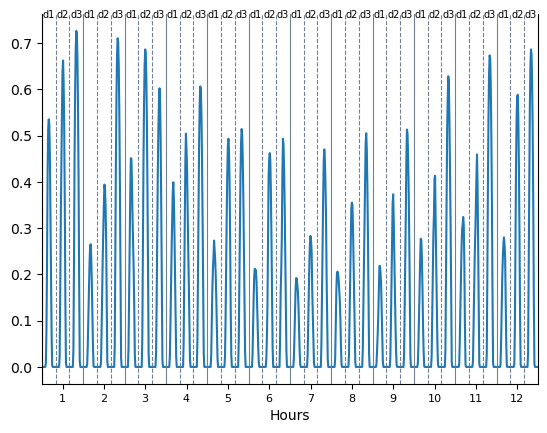

<Axes: xlabel='season'>

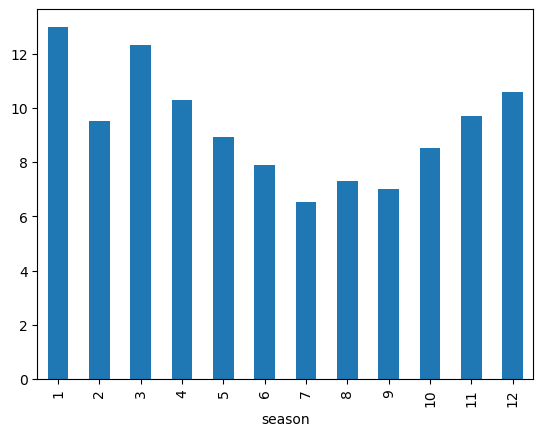

In [7]:
# Plot PV profile
path_file = os.path.join(main_folder, 'pVREProfile_{}.csv'.format(name_data))
df = pd.read_csv(path_file, index_col=[0, 1, 2, 3])
df = df.droplevel('zone', axis=0)
df = df.xs('PV', level='Power')
df = df.stack()
df.index.names = ['season', 'day', 'hour']
plot_dispatch(df)

df.groupby('season').sum().plot(kind='bar')


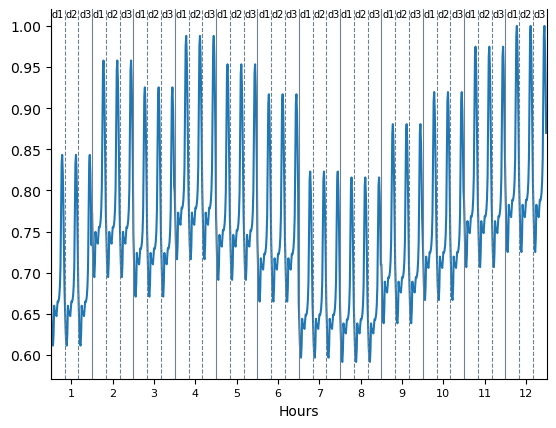

In [8]:
# Plot Demand profile
path_file = os.path.join(main_folder, 'pDemandProfile_{}.csv'.format(name_data))
df = pd.read_csv(path_file, index_col=[0, 1, 2])
df = df.droplevel('zone', axis=0)
df = df.stack()
df.index.names = ['season', 'day', 'hour']
plot_dispatch(df)